# Naive representation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 11) #random number of sources
radius = 1 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 6.70538406e+01+3.47318497e+01j -1.06424012e-03-9.58007853e-03j
  -2.32914407e-02+1.69761982e-02j  9.75508534e-04-8.77541304e-03j
   3.40196877e+01+9.54771118e+01j -5.19312860e-04-3.07056471e-03j
  -1.51774883e-02+5.05462196e-03j  8.25190824e-03+2.35212897e-03j
   1.35955736e-02-8.43188539e-03j -1.33862766e-02-5.57553314e-04j]
 [-1.49259148e-02+1.19272070e-02j -2.94292159e-03+2.31384337e-02j
   8.73067323e-03-1.80389080e-02j  2.96736625e-03-4.11271630e-03j
  -2.90503409e-02-4.15616145e-04j  9.73004010e-03+3.24458256e-03j
  -1.33453049e-02+1.33451987e-02j -3.48168169e-03+3.10611003e-03j
   1.24127907e-03-1.08987587e-02j  1.55408317e-02+1.21441521e-02j]
 [ 6.82918215e+00+7.87237549e+01j -1.93550240e-03+6.55761920e-03j
   1.05659594e-03+1.11933434e-02j  1.12283351e-02+5.18617686e-03j
  -1.30765967e-03-4.80984990e-03j -5.52907772e-03-7.77051784e-03j
   5.49002038e-03-6.07754686e-04j  6.02153587e+01+8.39376526e+01j
  -9.22377314e-03-1.03837615e-02j -6.68657850e-03+6.61374594e-04j]
 [ 2.23

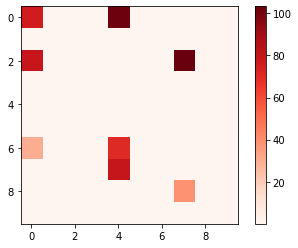

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 275.9893   +463.0384j     -30.810604  -47.3342j
   -76.04551  +174.95374j    441.9741   +142.66185j
  -219.43808  +160.32065j    113.26174  +230.9595j
   240.37402  -130.0767j     -81.10303  +458.15714j
   173.8032    +50.52835j    -48.685074  -65.78888j  ]
 [  81.9023   +131.14548j    252.69739   +87.317726j
   -70.67812   -88.743385j   242.60626  +126.383286j
   179.3977    -48.158993j   -66.622215 +133.9824j
   296.17123   -55.04518j     51.29062    -3.6975086j
   124.01463  +215.93692j    130.78203  -188.48752j  ]
 [ 216.39383  -173.97008j    151.73604   -69.38389j
   160.1076   +186.01163j     48.82113  -218.92157j
   163.478      -8.176303j   286.8089    +60.073124j
   -92.55128   -74.53383j    240.48582   -44.63291j
   243.21483   -71.235535j   -37.179966 +131.14389j  ]
 [ -23.3771   +135.44098j    144.48024  -305.81424j
  -156.08057  +250.67891j    101.155235  -25.101889j
  -170.35358  -250.13647j    168.7136   +277.30707j
   -49.825092 -166.605j     -228.40779   +22.987417j

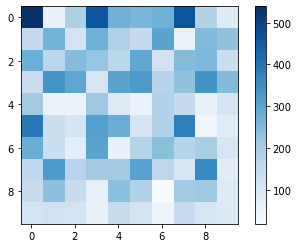

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

In [7]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 1.227006e-13
Imaginaries MSE: 1.2600463e-13


In [8]:
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [9]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [10]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)

In [13]:
# measurement
qc.measure_all()
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)
result = simulator.run(circ, shots=1, memory=True).result()
memory = result.get_memory(circ)[0]
print(memory)
out = reverse(memory)

#qc.measure_all()
#backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
#job = backend.run(qc, shots=1, memory=True) 
#output = job.result().get_memory()[0]
#out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

0011001111010001100101010100001000011111110100010001000001000010001101111000010110110011010000110111011010101000110010111111110110101101000101111000100011000010101101111111110000001011100000110010100001011100011000100100001011000110001111000110010010000010111001010100000111010100010000110010001000111000100100110100001001000101011011100001010101000010110101000110110111110111010000111110111100000000000011000100001010011111101100110010110001000010001101010001000111111010010000101000100101100010011000110100001011010001001011111010010001000011101100101001001111000111010000111010100101111000111100110100001000000010011001010000101001000010100011010000000011000100100000110101111011010010111101010100001110001011101011101101011001000010100101101101001000110010110000101000110100010101011011110100001110110111100100001110010011000011110010000010110110100010100000110111101101111111100110101000001100111010110000011011010011000010100011011110001011000010010000100011000110101011001101101100001111010001

In [ ]:
fidelity = np.fft.ifft2(readout).astype('complex64')

In [ ]:
test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(fidelity)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)